# Loading




In [1]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

In [2]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# returns JSON object as a dictionary
f = open('/content/drive/MyDrive/Iceberg/train.json',) # The train.json file needs to be in an "Iceberg" directory

# creating a dataframe
df_raw = pd.DataFrame(json.load(f))

# visualising the first rows
df_raw.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [4]:
# Visualising info
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1604 non-null   object
 1   band_1      1604 non-null   object
 2   band_2      1604 non-null   object
 3   inc_angle   1604 non-null   object
 4   is_iceberg  1604 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 62.8+ KB
None


# Data treatment

In [5]:
# Train/test split
df = df_raw.sample(frac = 0.8, random_state = 42)
df_test = df_raw.drop(df.index)

In [6]:
# Changing inc_angle from object to float64
df.replace('na', np.NaN, inplace = True) # Replacing the 'na' text in inc_angle by NaN
df['inc_angle'].astype('float', copy = False) # Casting inc_angle to float works with the NaN
df[df.inc_angle.isna()] # 133 NaN
print(df.info()) # inc_angle is now float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 530 to 546
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1283 non-null   object 
 1   band_1      1283 non-null   object 
 2   band_2      1283 non-null   object 
 3   inc_angle   1175 non-null   float64
 4   is_iceberg  1283 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 60.1+ KB
None


# Visualization

In [7]:
# Function to show pictures of both bands
def show_bands(row):
  f, (img1, img2) = plt.subplots(1, 2)
  img1.imshow(np.array(row.band_1).reshape(75,75))
  img1.set_title("band_1")
  img2.imshow(np.array(row.band_2).reshape(75,75))
  img2.set_title("band_2")
  plt.show()

Iceberg examples


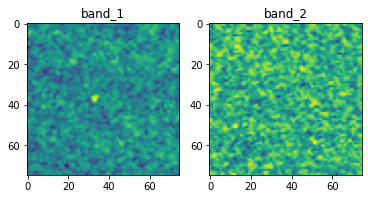

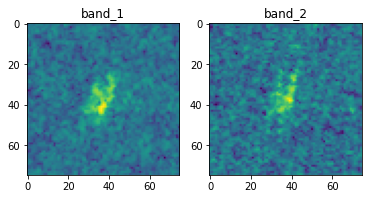

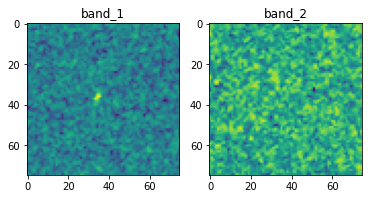

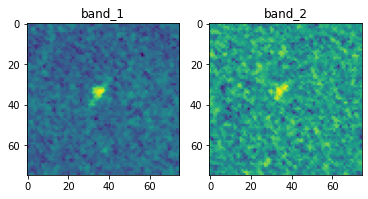

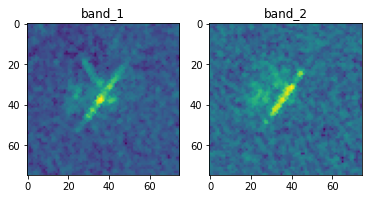

In [36]:
# 5 Iceberg examples
print("Iceberg examples")
df[df['is_iceberg'] == 1].sample(5, random_state = 3).apply(show_bands, axis=1)
print()

Boat examples


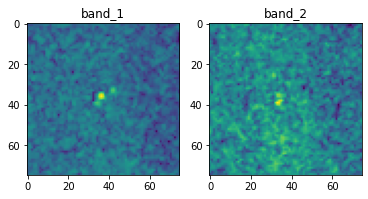

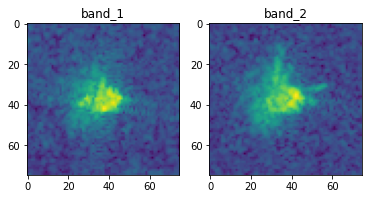

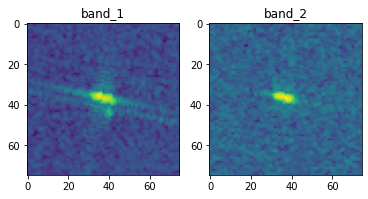

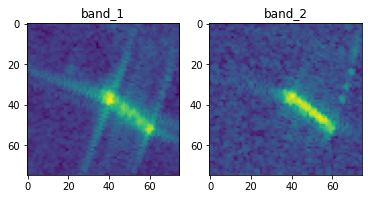

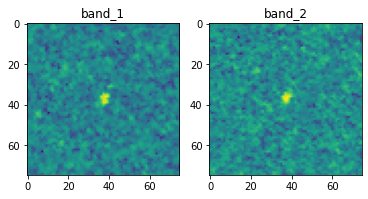

In [32]:
# 5 boat examples
print("Boat examples")
df[df['is_iceberg'] == 0].sample(5, random_state = 13).apply(show_bands, axis=1)
print()

# Image processing

https://scikit-image.org/docs/stable/user_guide.html




In [10]:
!pip uninstall scikit-image -y

!pip install -U scikit-image


Found existing installation: scikit-image 0.18.3
Uninstalling scikit-image-0.18.3:
  Successfully uninstalled scikit-image-0.18.3
  Using cached scikit_image-0.18.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (29.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [11]:
import skimage as sk
import skimage.filters as fl
import skimage.restoration as rs
#print(skimage.__version__)

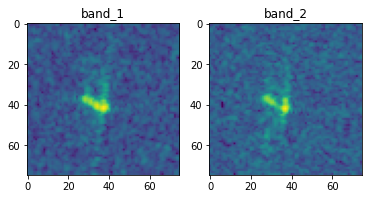

In [12]:
f, (i1, i2) = plt.subplots(1, 2)
img1 = np.array(df.iloc[4][df.columns.get_loc('band_1')]).reshape(75,75)
img2 = np.array(df.iloc[4][df.columns.get_loc('band_2')]).reshape(75,75)
i1.imshow(img1)
i1.set_title('band_1')
i2.imshow(img2)
i2.set_title('band_2')
plt.show()

In [18]:
df.iloc[4][df.columns.get_loc('is_iceberg')]

0

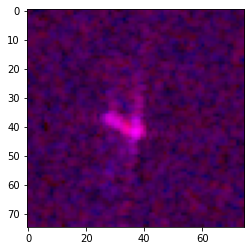

In [13]:
img1 = (img1 - img1.min())/(img1.max()-img1.min())
img2 = (img2 - img2.min())/(img2.max()-img2.min())
color = np.dstack((img1,np.zeros((75,75,1)),img2))
plt.imshow(color)

## Denoise

https://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html

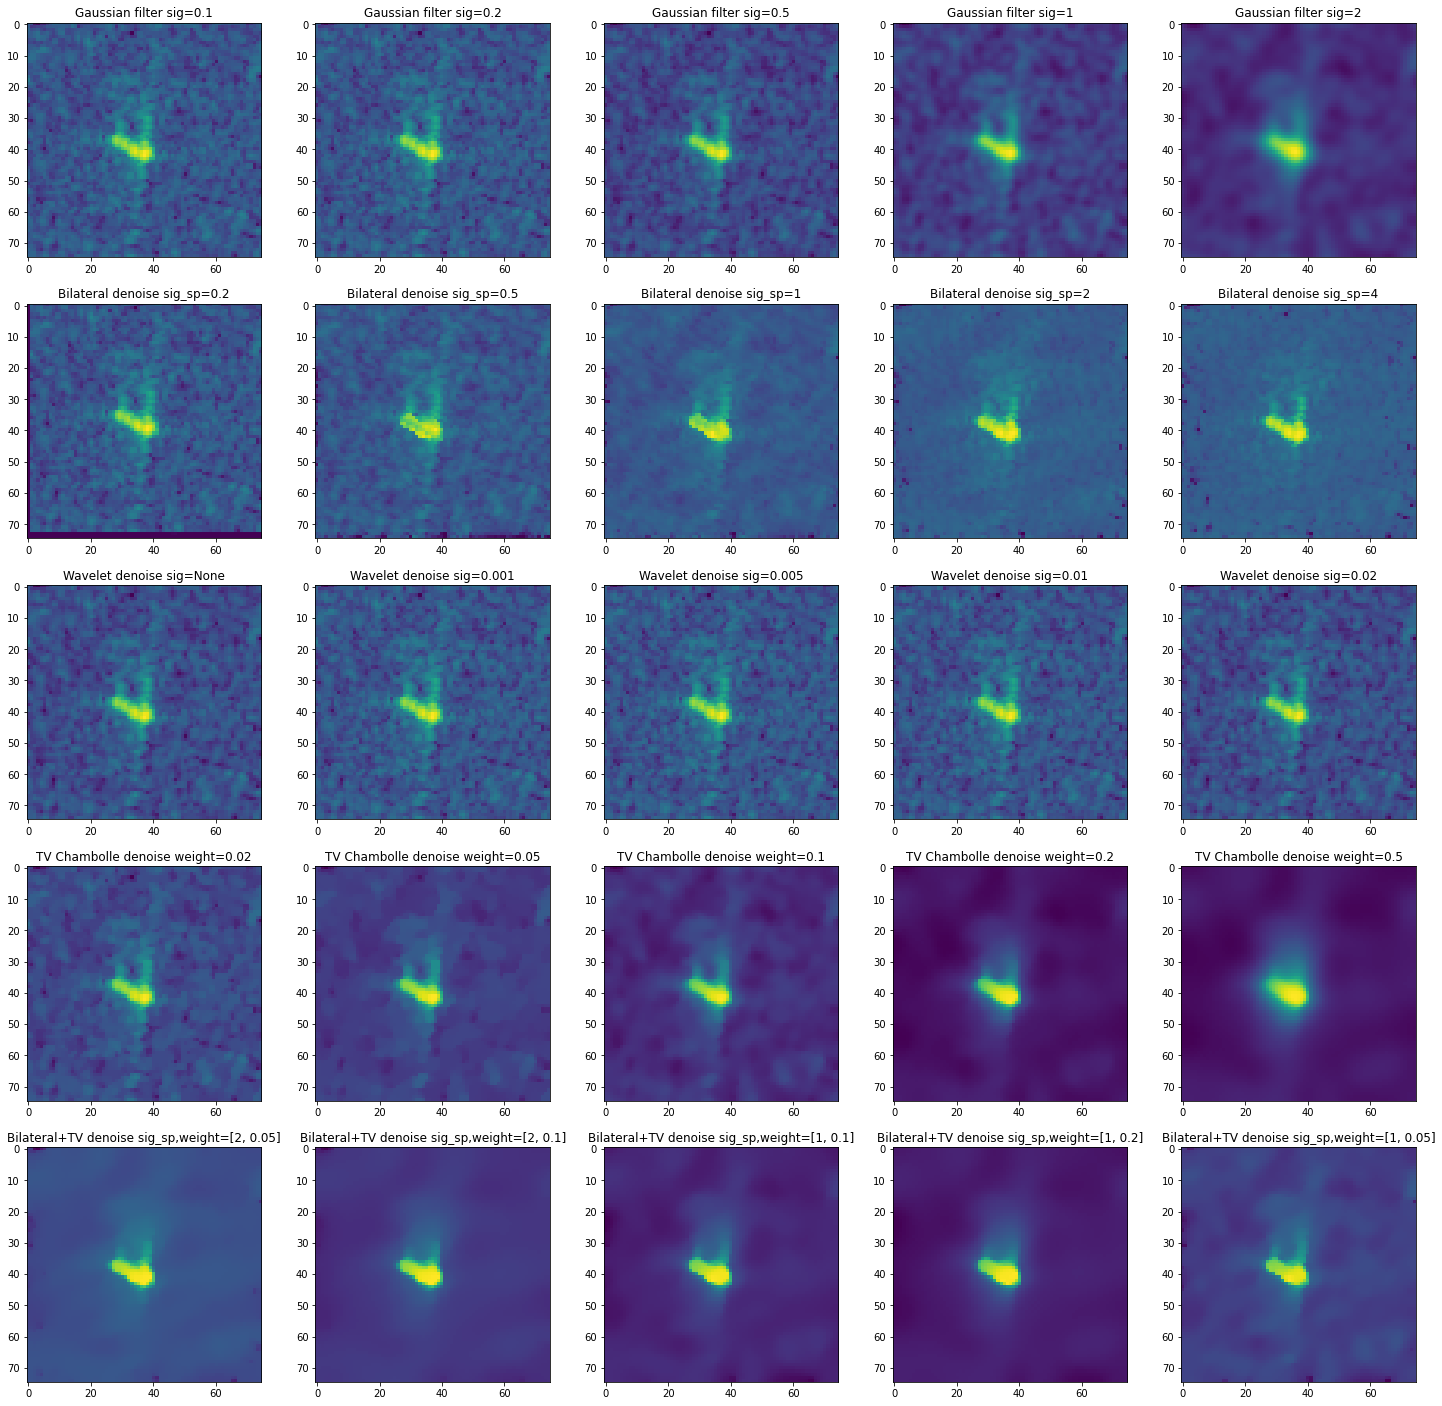

In [14]:
img = img1

f, axs = plt.subplots(5, 5, figsize=(25,25))

gaussian_sigma = [0.1, 0.2, 0.5, 1, 2] # rs.estimate_sigma(img) gives 0.02
bilateral_sigma_spatial = [0.2, 0.5, 1, 2, 4]
wavelet_sigma = [None, 0.001, 0.005, 0.01, 0.02]
tv_weight = [0.02, 0.05, 0.1, 0.2, 0.5]
bilateral_tv = [[2, 0.05],[2, 0.1],[1, 0.1],[1, 0.2],[1, 0.05]]

for i, c in enumerate(gaussian_sigma):
  axs[0][i].imshow(fl.gaussian(img, sigma = c))
  axs[0][i].set_title(f"Gaussian filter sig={c}")
for i, c in enumerate(bilateral_sigma_spatial):
  axs[1][i].imshow(rs.denoise_bilateral(img, sigma_spatial = c))
  axs[1][i].set_title(f"Bilateral denoise sig_sp={c}")
for i, c in enumerate(wavelet_sigma):
  axs[2][i].imshow(rs.denoise_wavelet(img, sigma = c, wavelet='coif1', rescale_sigma=True))
  axs[2][i].set_title(f"Wavelet denoise sig={c}")
for i, c in enumerate(tv_weight):
  axs[3][i].imshow(rs.denoise_tv_chambolle(img, weight = c))
  axs[3][i].set_title(f"TV Chambolle denoise weight={c}")
for i, c in enumerate(bilateral_tv):
  axs[4][i].imshow(rs.denoise_tv_chambolle(rs.denoise_bilateral(img, sigma_spatial = c[0]), weight = c[1]))
  axs[4][i].set_title(f"Bilateral+TV denoise sig_sp,weight={c}")

/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning:

Level value of 1 is too high: all coefficients will experience boundary effects.



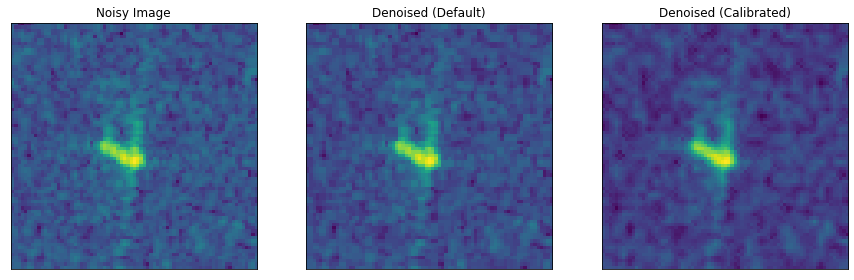

In [15]:
from functools import partial
import pywt

# rescale_sigma=True required to silence deprecation warnings
_denoise_wavelet = partial(rs.denoise_wavelet, rescale_sigma=True)

# Parameters to test when calibrating the denoising algorithm
parameter_ranges = {'sigma': np.arange(0.01, 0.1, 0.01),
                    'wavelet': ['coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 
                                'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 
                                'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 
                                'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 
                                'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 
                                'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 
                                'sym16', 'sym17', 'sym18', 'sym19', 'sym20']}

#pywt.wavelist(kind='discrete')} #['db1', 'db2']

# Denoised image using default parameters of `denoise_wavelet`
default_output = rs.denoise_wavelet(img, rescale_sigma=True)

# Calibrate denoiser
calibrated_denoiser = rs.calibrate_denoiser(img,
                                         _denoise_wavelet,
                                         denoise_parameters=parameter_ranges)

# Denoised image using calibrated denoiser
calibrated_output = calibrated_denoiser(img)

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

for ax, toprint, title in zip(
        axes,
        [img, default_output, calibrated_output],
        ['Noisy Image', 'Denoised (Default)', 'Denoised (Calibrated)']
):
    ax.imshow(toprint)
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xticks([])

In [16]:
calibrated_denoiser

functools.partial(<function _invariant_denoise at 0x7ff43d02db00>, denoise_function=functools.partial(<function denoise_wavelet at 0x7ff43a36b830>, rescale_sigma=True), stride=4, denoiser_kwargs={'sigma': 0.03, 'wavelet': 'coif1'})

# Edge detection

https://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html?highlight=gradient

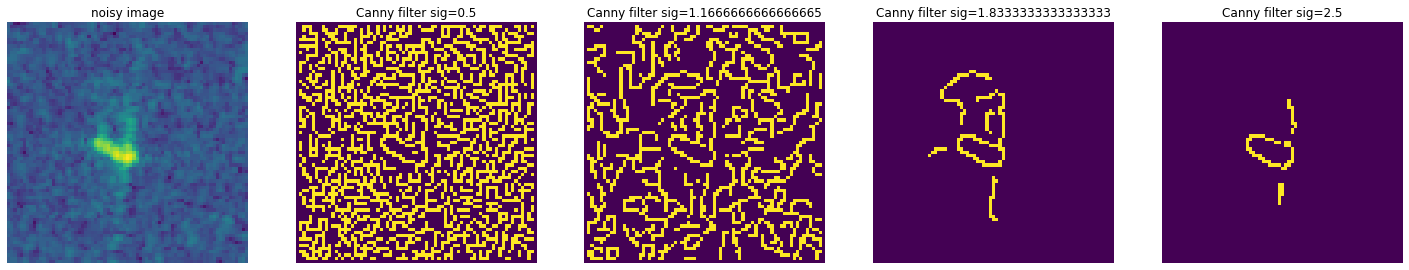

In [29]:
from skimage import feature

#image = rs.denoise_tv_chambolle(rs.denoise_bilateral(img, sigma_spatial = 1), weight = 0.1)
image = img

sigma = np.linspace(0.5,2.5,4)

# display results
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25,5))

axs[0].imshow(image)
axs[0].set_title('noisy image')
for i, c in enumerate(sigma):
  axs[i+1].imshow(feature.canny(image, sigma = c))
  axs[i+1].set_title(f"Canny filter sig={c}")

for a in axs:
    a.axis('off')
plt.show()

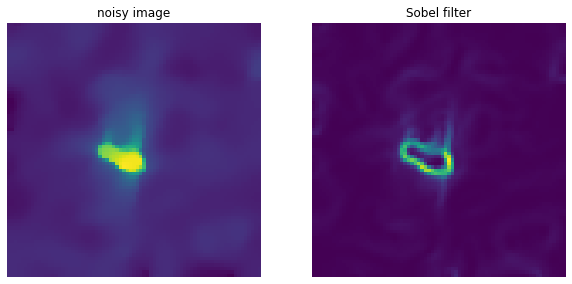

In [45]:
from skimage.filters import sobel

image = rs.denoise_tv_chambolle(rs.denoise_bilateral(img, sigma_spatial = 1), weight = 0.1)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axs[0].imshow(image)
axs[0].set_title('noisy image')
axs[1].imshow(sobel(image))
axs[1].set_title("Sobel filter")
for a in axs:
    a.axis('off')
plt.show()